In [1]:
pip install networkx pandas openpyxl python-louvain sumy


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached python-louvain-0.16.tar.gz (204 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached sumy-0.11.0-py2.py3-none-any.whl.metadata (7.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached breadability-0.1.20-py2.py3-none-any.whl
  Using cached pycountry-24.6.1-py3-none-any.whl.metadata (12 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached chardet-5.2.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached lxml-5.3.2-cp311-cp311-win_amd64.whl.meta

In [3]:

import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
from collections import defaultdict

df = pd.read_excel("pairwise_similarity.xlsx")
threshold = 0.35

G = nx.Graph()
for _, row in df.iterrows():
    if row["Similarity Score"] >= threshold:
        G.add_edge(row["Tweet 1"], row["Tweet 2"], weight=row["Similarity Score"])

partition = community_louvain.best_partition(G)
communities = defaultdict(list)
for tweet, community_id in partition.items():
    communities[community_id].append(tweet)

similarity_dict = defaultdict(dict)
for _, row in df.iterrows():
    t1, t2, score = row["Tweet 1"], row["Tweet 2"], row["Similarity Score"]
    if score >= threshold:
        similarity_dict[t1][t2] = score
        similarity_dict[t2][t1] = score  # Ensure symmetry

def weighted_lexrank_with_similarity(sentences, top_n=45):
    if len(sentences) <= top_n:
        return sentences

    graph = nx.Graph()
    for i, s1 in enumerate(sentences):
        for j in range(i + 1, len(sentences)):
            s2 = sentences[j]
            score = similarity_dict.get(s1, {}).get(s2, 0)
            if score >= threshold:
                graph.add_edge(i, j, weight=score)

    if len(graph.nodes) == 0:
        return sentences[:top_n]

    scores = nx.pagerank(graph, weight='weight')
    ranked = sorted(((scores[i], sentences[i]) for i in scores), reverse=True)
    return [s for _, s in ranked[:top_n]]

community_summaries = {}
for cid, tweets in communities.items():
    unique_tweets = list(set(tweets))
    summary = weighted_lexrank_with_similarity(unique_tweets, top_n=min(40, len(unique_tweets)))
    community_summaries[cid] = summary

all_community_sentences = []
for s in community_summaries.values():
    all_community_sentences.extend(s)

final_summary = weighted_lexrank_with_similarity(all_community_sentences, top_n=45)

with pd.ExcelWriter("community_summaries_output.xlsx", engine='openpyxl') as writer:
    for cid, summary in community_summaries.items():
        pd.DataFrame(summary, columns=[f"Community {cid} Summary"]).to_excel(writer, sheet_name=f"Community_{cid}", index=False)
    pd.DataFrame(final_summary, columns=["Final Summary"]).to_excel(writer, sheet_name="Final_Summary", index=False)

print("✅ Task completed successfully! Weighted LexRank summaries saved using pairwise similarity.")


✅ Task completed successfully! Weighted LexRank summaries saved using pairwise similarity.


In [23]:

# Print number of tweets in each community
for cid, tweets in communities.items():
    print(f"Community {cid}: {len(tweets)} tweets")


Community 0: 121 tweets
Community 2: 109 tweets
Community 1: 121 tweets
Community 3: 133 tweets



👨 Matched Male Terms and Frequencies:
men: 10
man: 4
him: 2
his: 2
he: 2
boys: 1
masculinity: 1
manhood: 1

👩 Matched Female Terms and Frequencies:
women: 25
girls: 6
feminism: 3
woman: 3
her: 3
feminist: 2
she: 2
femininity: 1
females: 1
lady: 1

🧮 Total Gendered Mentions: 70
📘 Weighted Male Score: 0.328571
📕 Weighted Female Score: 0.671429
📈 Weighted Inclusion Bias Score (F - M): 0.342857


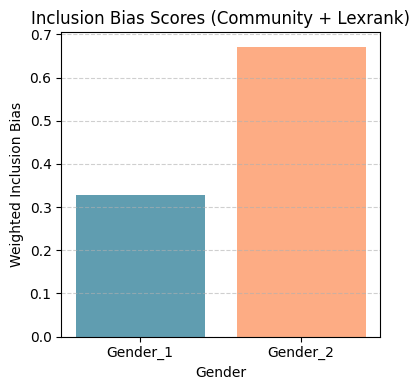

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load the Excel summary file
df = pd.read_excel("community_summaries_output.xlsx", sheet_name="Final_Summary")

# Convert all summaries to lowercase
df['Final Summary'] = df['Final Summary'].astype(str).str.lower()

# Load gendered terms
male_terms = set(pd.read_csv("male_list.csv", header=None)[0].str.lower().str.strip())
female_terms = set(pd.read_csv("female_list.csv", header=None)[0].str.lower().str.strip())

# Combine all summaries into one string
full_text = " ".join(df['Final Summary'].tolist())
words = [word.strip('.,!?()[]{};:\'"') for word in full_text.split()]

# Count word frequencies
word_freq = Counter(words)

# Extract matched gendered words and their frequencies
matched_male = {w: freq for w, freq in word_freq.items() if w in male_terms}
matched_female = {w: freq for w, freq in word_freq.items() if w in female_terms}

# Total gendered words only
total_gendered_words = sum(matched_male.values()) + sum(matched_female.values())

# Avoid division by zero
if total_gendered_words == 0:
    male_score = female_score = bias_score = 0.0
else:
    male_score = sum(matched_male.values()) / total_gendered_words
    female_score = sum(matched_female.values()) / total_gendered_words
    bias_score = female_score - male_score

# 🔍 Print matched gendered terms and frequencies
print("\n👨 Matched Male Terms and Frequencies:")
for w, freq in sorted(matched_male.items(), key=lambda x: -x[1]):
    print(f"{w}: {freq}")

print("\n👩 Matched Female Terms and Frequencies:")
for w, freq in sorted(matched_female.items(), key=lambda x: -x[1]):
    print(f"{w}: {freq}")

# 📊 Print score summary
print(f"\n🧮 Total Gendered Mentions: {total_gendered_words}")
print(f"📘 Weighted Male Score: {male_score:.6f}")
print(f"📕 Weighted Female Score: {female_score:.6f}")
print(f"📈 Weighted Inclusion Bias Score (F - M): {bias_score:.6f}")

# 📊 Plotting
# 🖼️ Consistent Styling Plot
plt.figure(figsize=(4, 4))  # Match compact size like original
plt.bar(["Gender_1", "Gender_2"], [male_score, female_score], color=["#609db0", "#fdac84"])
plt.title("Inclusion Bias Scores (Community + Lexrank)")
plt.ylabel("Weighted Inclusion Bias")
plt.xlabel("Gender")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
pip install matplotlib

  Using cached pillow-11.1.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 3.7 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 3.8 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 4.3 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 4.3 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/8.1 MB 4.4 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 4.4 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 4.2 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- -----------